<a href="https://colab.research.google.com/github/supsi-dacd-isaac/TeachDecisionMakingUncertainty/blob/main/07/IPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Minimax Regression: Finding an Interpolating Polynomial

This script solves the minimax regression problem where we aim to find the coefficients of a cubic polynomial that minimizes the vertical strip containing all data points.


We are given $ N = 2000 $ data set of points $$\mathcal{D} = \{(u^{(i)}, y^{(i)})\}_{i=1}^{N}. $$


Our goal is to optimize the coefficients of a polynomial model:

$$
y = a_0 + a_1 u + a_2 u^2 + a_3 u^3
$$

capable of capturing the trend and uncertainty in the data.

### **Problem Formulation**
In mathematical terms, this problem can be casted as the following optimization program:

\begin{aligned}
\min_{a} \quad & a_4 \\
\text{subject to} \quad & |y^{(i)} - f(u^{(i)},a)| \leq a_4, \quad i = 1, 2, \dots, N
\end{aligned}


### **Discussion:**

* The parameters $(a_0, a_1, a_2, a_3)$ must be chosen so that the maximum absolute vertical distance from each point to the polynomial is minimized ($a_4$).

* This procedure yiels a model $f(u,a) \pm a_4$ known as interval predictor model.

* With our usual notation, the performance function $g(a,u^{i})\leq 0, i = 1, 2, \dots, N$ with $g(a,u{(i)}) = |y^{(i)} - f(u^{i},a)|-a_4 $ defines our problem.

* The $N$ random samples define $N$ random (hard) constraints.



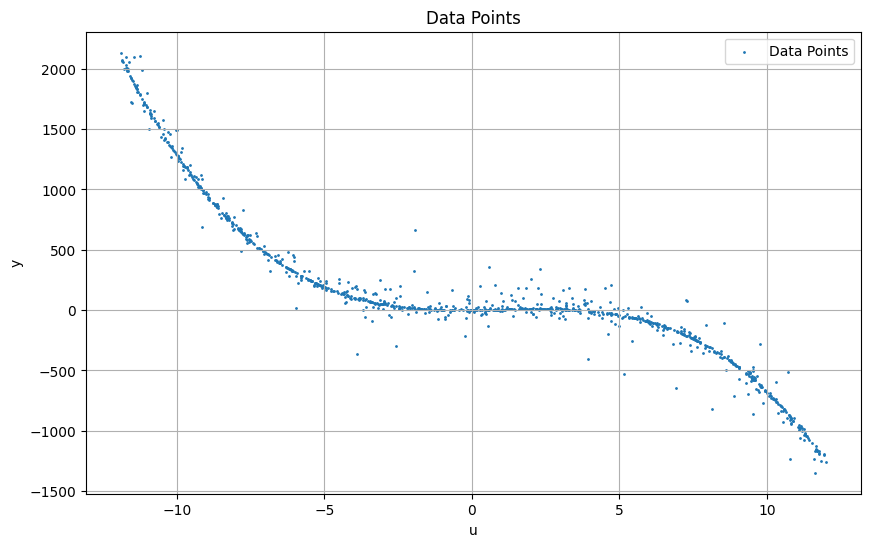

In [101]:
import numpy as np
import cvxpy as cp  # library for convex optimization
import matplotlib.pyplot as plt
# Generate sample data

## WE WILL ASSUME THIS GENERATIVE PROCESS IS UNKNOWN TO US (OFTEN THE CASE IN PRACTICE)

def DGM(n_samples: int = 500):
  np.random.seed(42)  # for reproducibility...(always generates the same sequence of random numbers)
  u = np.random.uniform(-12, 12, n_samples)  # randomly generate u_i values in an interval
  y = 2 * u + 3 * u**2 - u**3 + 20 * np.random.randn(n_samples)**3 # corresponding y values with noise

  return u, y

u, y = DGM(1000)

# Plot the data points and the optimal polynomial
plt.figure(figsize=(10, 6))
plt.scatter(u, y, label='Data Points', s=1)  # Plot data points
plt.grid()
plt.xlabel('u')
plt.ylabel('y')
plt.title('Data Points')
plt.legend()
plt.show()

In [102]:
# Define the polynomial coefficients and the vertical strip width (x4)
a0 = cp.Variable()
a1 = cp.Variable()
a2 = cp.Variable()
a3 = cp.Variable()
a4 = cp.Variable(nonneg=True) # Ensure x4 is non-negative

# Define the polynomial function for each point
polynomial = a0 + a1 * u + a2 * u**2 + a3 * u**3

# Define the constraints for each data point
constraints = [cp.abs(y[i] - polynomial[i]) <= a4 for i in range(N)]

# Objective is to minimize x4
objective = cp.Minimize(a4)

# Define the problem
problem = cp.Problem(objective, constraints)

# Solve the problem
problem.solve()

# Output the results
print(f"Optimal polynomial is {a0.value} + {a1.value} * u + {a2.value} * u**2 + {a3.value} * u**3 +- {a4.value}: ")
a4_all_samples = a4.value

Optimal polynomial is 123.05288318537224 + 3.094551753038857 * u + 0.26763861286101226 * u**2 + -1.0119865059052497 * u**3 +- 540.4679657518338: 


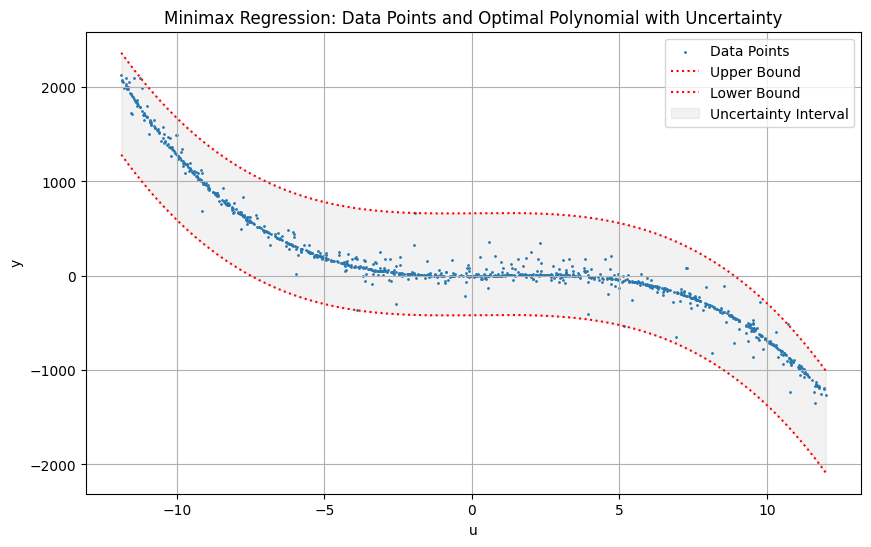

In [103]:
import matplotlib.pyplot as plt

# Create the polynomial functions
optimal_polynomial_up = lambda u: a0.value + a1.value * u + a2.value * u**2 + a3.value * u**3 + a4.value
optimal_polynomial_down = lambda u: a0.value + a1.value * u + a2.value * u**2 + a3.value * u**3 - a4.value

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(u, y, label='Data Points', s=1)  # Plot data points

# Plot the polynomials
plt.plot(np.sort(u), optimal_polynomial_up(np.sort(u)), color='red', linestyle=':', label='Upper Bound')
plt.plot(np.sort(u), optimal_polynomial_down(np.sort(u)), color='red', linestyle=':', label='Lower Bound')

# Fill the area between the upper and lower bounds
plt.fill_between(np.sort(u), optimal_polynomial_up(np.sort(u)), optimal_polynomial_down(np.sort(u)), color='gray', alpha=0.1, label='Uncertainty Interval')

# Set labels and title
plt.xlabel('u')
plt.ylabel('y')
plt.title('Minimax Regression: Data Points and Optimal Polynomial with Uncertainty')
plt.legend()
plt.grid(True)
plt.show()

One would like to have a strip of small width so as to make a tight prediction, while keeping low the probability of not capturing the next unseen y, that is the probability of predicting correctly new sampels:

$$\mathbb{P}[(u,y) \in [f(u)- a_4, f(u)- a_4]]$$

of a new sample falling
outside the strip is small.

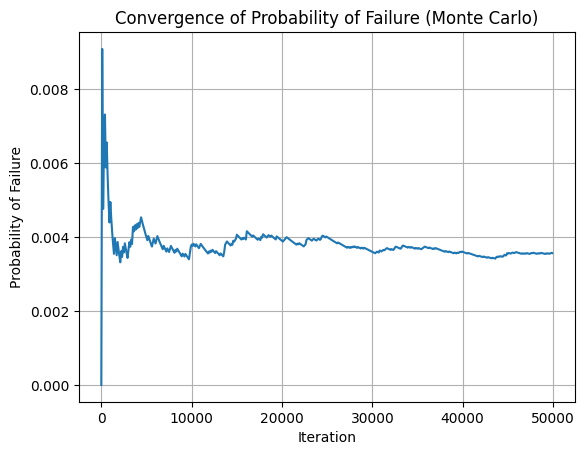

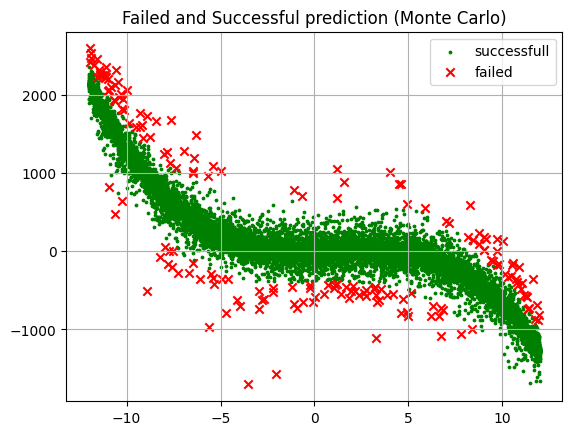

In [121]:
#@title monte carlo to estimate the probability of not predicting well new samples
def monte_carlo_probability(u_test, y_test, a0, a1, a2, a3, a4, num_samples=1_000):
    """
    Estimates the probability of
    a sample falling outside the bounds using Monte Carlo sampling.
    """
    # Generate random samples within a range
    u, y = DGM(num_samples)
    # Check if the sample falls outside the bounds
    lower_bound = a0.value + a1.value * u + a2.value * u**2 + a3.value * u**3 - a4.value
    upper_bound = a0.value + a1.value * u + a2.value * u**2 + a3.value * u**3 + a4.value
    Indicator_function = np.logical_and(lower_bound <= y, y<= upper_bound)
    reliability = np.mean(Indicator_function)
    unreliability = 1 - reliability
    return reliability, unreliability, Indicator_function, u, y


# Assuming you have already defined DGM, a0, a1, a2, a3, a4, u, and y from your previous code
# Example usage: replace with your actual values of u and y
num_samples = 50_000
reliability, unreliability, Indicator_function, u_mc, y_mc = monte_carlo_probability(u, y, a0, a1, a2, a3, a4, num_samples=num_samples)

n_samples = len(Indicator_function)
x_2plot = range(10, n_samples, 100)
unreliability_convergence = [1-np.mean(Indicator_function[:k]) for k in x_2plot]
plt.plot(x_2plot, unreliability_convergence ) #Corrected iteration
plt.xlabel("Iteration")
plt.ylabel("Probability of Failure") #Corrected label to "probability of success"
plt.title("Convergence of Probability of Failure (Monte Carlo)")
plt.grid(True)
plt.show()



plt.scatter(u_mc[Indicator_function], y_mc[Indicator_function], 3, marker='o', c='green', label='successfull')
plt.scatter(u_mc[Indicator_function==False], y_mc[Indicator_function==False], marker='x', c='red', label='failed')  # Plot data points
plt.title("Failed and Successful prediction (Monte Carlo)")
plt.legend()
plt.grid(True)
plt.show()

Indices of active constraints: [100 281 321 835 869]


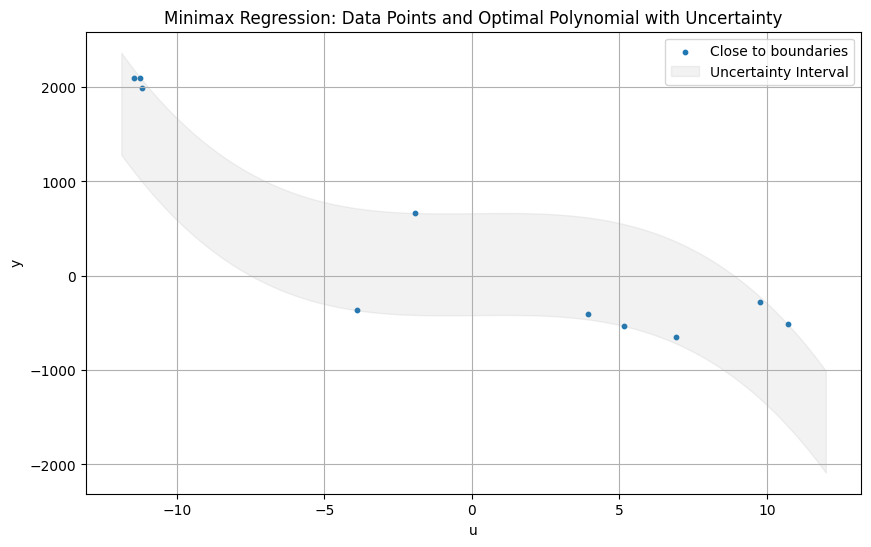

In [105]:
#@title Can we do better? can we remove 1% of the saampls to improve precision and do not lose so much in reliability?
g_fun = lambda u, y : (np.abs(y - (a0.value + a1.value * u + a2.value * u**2 + a3.value * u**3)) - a4.value)
scores = g_fun(u,y)

active_constraints_indices = np.where(np.abs(scores) < 1e-3)[0]
print("Indices of active constraints:", active_constraints_indices)

is_close_2_boundary = np.abs(scores) < np.quantile(np.abs(scores), 0.01) #remove 1 % of the closest points to the boundary

plt.figure(figsize=(10, 6))

plt.scatter(u[is_close_2_boundary], y[is_close_2_boundary], label='Close to boundaries', s=10)  # Plot data points

# Fill the area between the upper and lower bounds
plt.fill_between(np.sort(u), optimal_polynomial_up(np.sort(u)), optimal_polynomial_down(np.sort(u)), color='gray', alpha=0.1, label='Uncertainty Interval')

# Set labels and title
plt.xlabel('u')
plt.ylabel('y')
plt.title('Minimax Regression: Data Points and Optimal Polynomial with Uncertainty')
plt.legend()
plt.grid(True)
plt.show()

In [106]:
y_pruned , u_pruned  = y[is_close_2_boundary==False], u[is_close_2_boundary==False]

N_prun = len(u_pruned)

# Define the polynomial coefficients and the vertical strip width (x4)
a0_pruned = cp.Variable()
a1_pruned  = cp.Variable()
a2_pruned  = cp.Variable()
a3_pruned  = cp.Variable()
a4_pruned  = cp.Variable(nonneg=True) # Ensure x4 is non-negative

# Define the polynomial function for each point
polynomial = a0_pruned  + a1_pruned  * u_pruned + a2_pruned  * u_pruned**2 + a3_pruned  * u_pruned**3

# Define the constraints for each data point
constraints = [cp.abs(y_pruned[i] - polynomial[i]) <= a4_pruned  for i in range(N_prun)]

# Objective is to minimize x4
objective = cp.Minimize(a4_pruned )

# Define the problem
problem = cp.Problem(objective, constraints)

# Solve the problem
problem.solve()

# Output the results
print(f"Optimal polynomial is {a0_pruned .value} + {a1_pruned .value} * u + {a2_pruned .value} * u**2 + {a3_pruned .value} * u**3 +- {a4_pruned .value}: ")
a4_pruned_val = a4_pruned .value

Optimal polynomial is 39.01184459285095 + -10.864606317772987 * u + 1.174910919840125 * u**2 + -0.8542174004036042 * u**3 +- 390.7132728446999: 


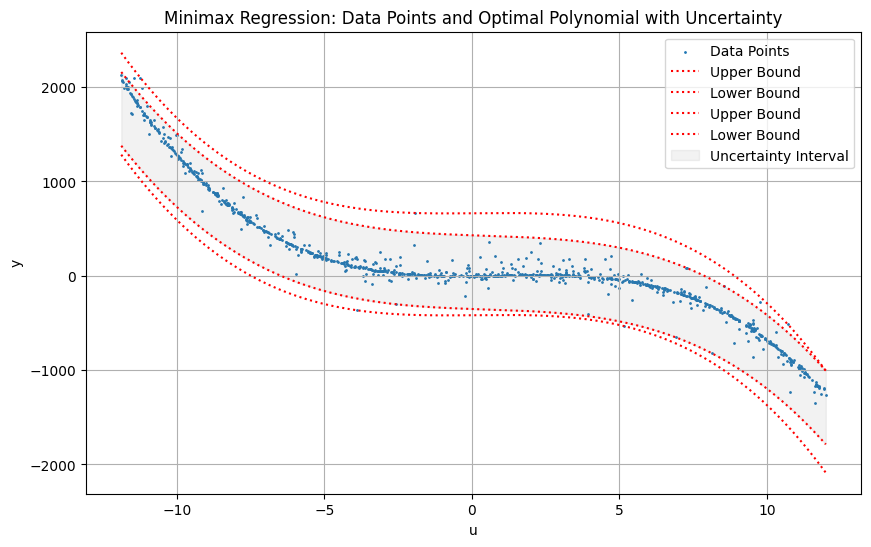

In [107]:




# Create the plot
plt.figure(figsize=(10, 6))# Plot the polynomials

plt.scatter(u, y, label='Data Points', s=1)  # Plot data points


plt.plot(np.sort(u), optimal_polynomial_up(np.sort(u)), color='red', linestyle=':', label='Upper Bound')
plt.plot(np.sort(u), optimal_polynomial_down(np.sort(u)), color='red', linestyle=':', label='Lower Bound')

# Create the polynomial functionsfor the new results
optimal_polynomial_up = lambda u: a0_pruned.value + a1_pruned.value * u + a2_pruned.value * u**2 + a3_pruned.value * u**3 + a4_pruned.value
optimal_polynomial_down = lambda u: a0_pruned.value + a1_pruned.value * u + a2_pruned.value * u**2 + a3_pruned.value * u**3 - a4_pruned.value

# Plot the polynomials
plt.plot(np.sort(u), optimal_polynomial_up(np.sort(u)), color='red', linestyle=':', label='Upper Bound')
plt.plot(np.sort(u), optimal_polynomial_down(np.sort(u)), color='red', linestyle=':', label='Lower Bound')

# Fill the area between the upper and lower bounds
plt.fill_between(np.sort(u), optimal_polynomial_up(np.sort(u)), optimal_polynomial_down(np.sort(u)), color='gray', alpha=0.1, label='Uncertainty Interval')

# Set labels and title
plt.xlabel('u')
plt.ylabel('y')
plt.title('Minimax Regression: Data Points and Optimal Polynomial with Uncertainty')
plt.legend()
plt.grid(True)
plt.show()


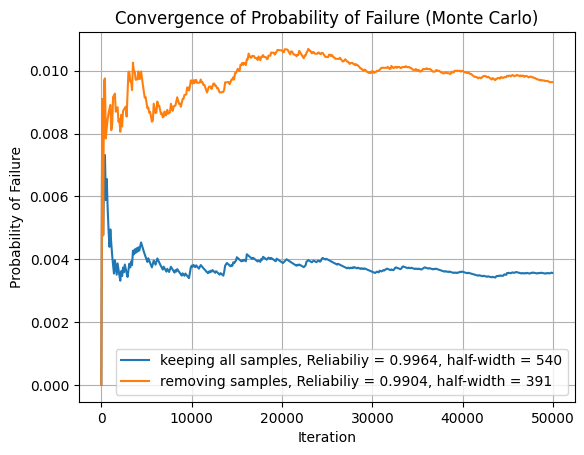

In [138]:
#@title compare reliabitliy and prediction width for the two models
# Example usage: replace with your actual values of u and y
num_samples = 50_000
reliability_pruned, unreliability_pruned, Indicator_function_pruned, u_mc, y_mc = monte_carlo_probability(u, y, a0=a0_pruned, a1=a1_pruned, a2=a2_pruned, a3=a3_pruned, a4=a4_pruned, num_samples=num_samples)

n_samples = len(Indicator_function_pruned)
x_2plot = range(10, n_samples, 100)
unreliability_convergence_pruned = [1-np.mean(Indicator_function_pruned[:k]) for k in x_2plot]

plt.plot(x_2plot, unreliability_convergence , label=f'keeping all samples, Reliabiliy = {1-unreliability_convergence[-1]:.4f}, half-width = {a4_all_samples:.0f}') #Corrected iteration
plt.plot(x_2plot, unreliability_convergence_pruned , label=f'removing samples, Reliabiliy = {1-unreliability_convergence_pruned[-1]:.4f}, half-width = {a4_pruned_val :.0f}') #Corrected iteration

plt.xlabel("Iteration")
plt.ylabel("Probability of Failure") #Corrected label to "probability of success"
plt.legend()
plt.title("Convergence of Probability of Failure (Monte Carlo)")
plt.grid(True)
plt.show()


In [135]:
def identify_minmax_IPM(data, n_steps: int =10, do_plot=True):
  u, y = data[0], data[1]
  plt.figure(figsize=(10, 6))

  unreliability_pruned_list = []
  width_list = []
  n_removed_list = []

  for step in range(n_steps):

      N = len(u)
      n_removed_list.append(N)

      # Define the polynomial coefficients and the vertical strip width (x4)
      a0 = cp.Variable()
      a1 = cp.Variable()
      a2 = cp.Variable()
      a3 = cp.Variable()
      a4 = cp.Variable(nonneg=True) # Ensure x4 is non-negative

      polynomial = a0 + a1 * u + a2 * u**2 + a3 * u**3  # Define the polynomial function for each point

      # Define the constraints for each data point
      constraints = [cp.abs(y[i] - polynomial[i]) <= a4 for i in range(N)]

      objective = cp.Minimize(a4)  # Objective is to minimize x4

      # Define the problem
      problem = cp.Problem(objective, constraints)

      # Solve the problem
      problem.solve()

      # Output the results
      print(f"Optimal polynomial is {a0.value} + {a1.value} * u + {a2.value} * u**2 + {a3.value} * u**3 +- {a4.value}: ")

      reliability_pruned, unreliability_pruned, _, _, _ = monte_carlo_probability(u, y, a0, a1, a2, a3, a4, num_samples=num_samples)

      unreliability_pruned_list.append(unreliability_pruned.round(4))
      width_list.append(a4.value)


      # remove samples
      print('removing boundary constraints')
      g_fun = lambda u, y : (np.abs(y - (a0.value + a1.value * u + a2.value * u**2 + a3.value * u**3)) - a4.value)
      scores = g_fun(u,y)
      is_close_2_boundary = np.abs(scores) <= 1e-3

      if do_plot:
        # Create the plot
        if step==0:
          plt.scatter(u, y, label='Data Points', s=1)  # Plot data points

        plt.scatter(u[is_close_2_boundary], y[is_close_2_boundary], label='Close to boundaries', s=10, c='r')  # Plot data points

      y, u = y[is_close_2_boundary==False], u[is_close_2_boundary==False]

      # Create the polynomial functions
      optimal_polynomial_up = lambda u: a0.value + a1.value * u + a2.value * u**2 + a3.value * u**3 + a4.value
      optimal_polynomial_down = lambda u: a0.value + a1.value * u + a2.value * u**2 + a3.value * u**3 - a4.value

      # Fill the area between the upper and lower bounds
      plt.fill_between(np.sort(u), optimal_polynomial_up(np.sort(u)), optimal_polynomial_down(np.sort(u)), color='gray', alpha=0.1, label='Uncertainty Interval')
      plt.xlabel('u')
      plt.ylabel('y')
      plt.title('Minimax Regression: Data Points and Optimal Polynomial with Uncertainty')
      plt.legend()
      plt.grid(True)
  plt.show()
  return unreliability_pruned_list, width_list, n_removed_list


Optimal polynomial is -66.10045689142304 + 65.9008652933257 * u + 3.5492792717166166 * u**2 + -1.579445009143195 * u**3 +- 871.8485052226796: 
removing boundary constraints
Optimal polynomial is -220.42137378659137 + -12.923134674848558 * u + 6.8091063512632966 * u**2 + -0.850145012682284 * u**3 +- 806.7877943786466: 
removing boundary constraints
Optimal polynomial is -214.2582825755114 + -10.459548830405344 * u + 6.716238908803465 * u**2 + -0.8923190200633117 * u**3 +- 730.1581698393605: 
removing boundary constraints
Optimal polynomial is -117.82999933919264 + 7.623720402889716 * u + 5.2528609630716625 * u**2 + -1.1048148366135258 * u**3 +- 534.9208485911635: 
removing boundary constraints
Optimal polynomial is -119.38491478984949 + 10.339267184508085 * u + 5.521819939518471 * u**2 + -1.1177575313144377 * u**3 +- 525.97171364435: 
removing boundary constraints


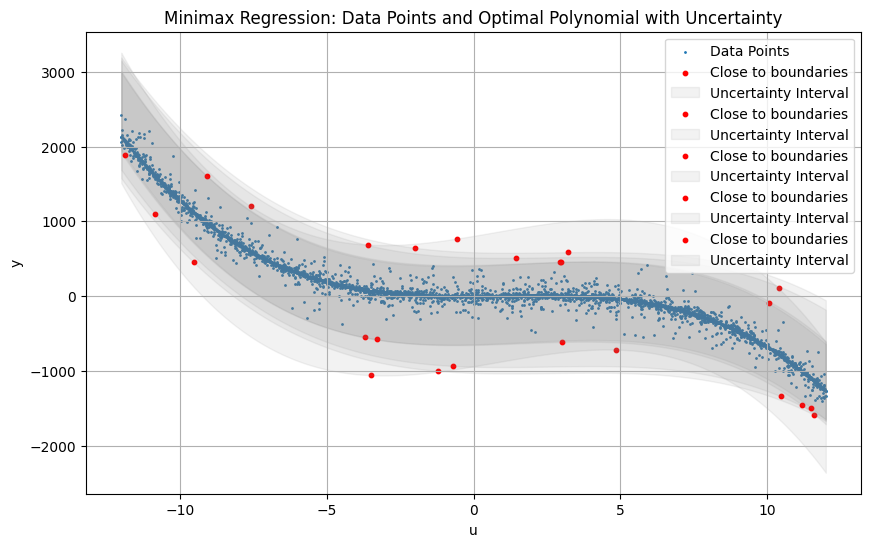

In [145]:
n_start_samples = 5_000
# Generate sample data
u,y  =DGM(n_start_samples)
unreliability_pruned_list, width_list, n_removed_list = identify_minmax_IPM(data=[u,y], n_steps = 5)

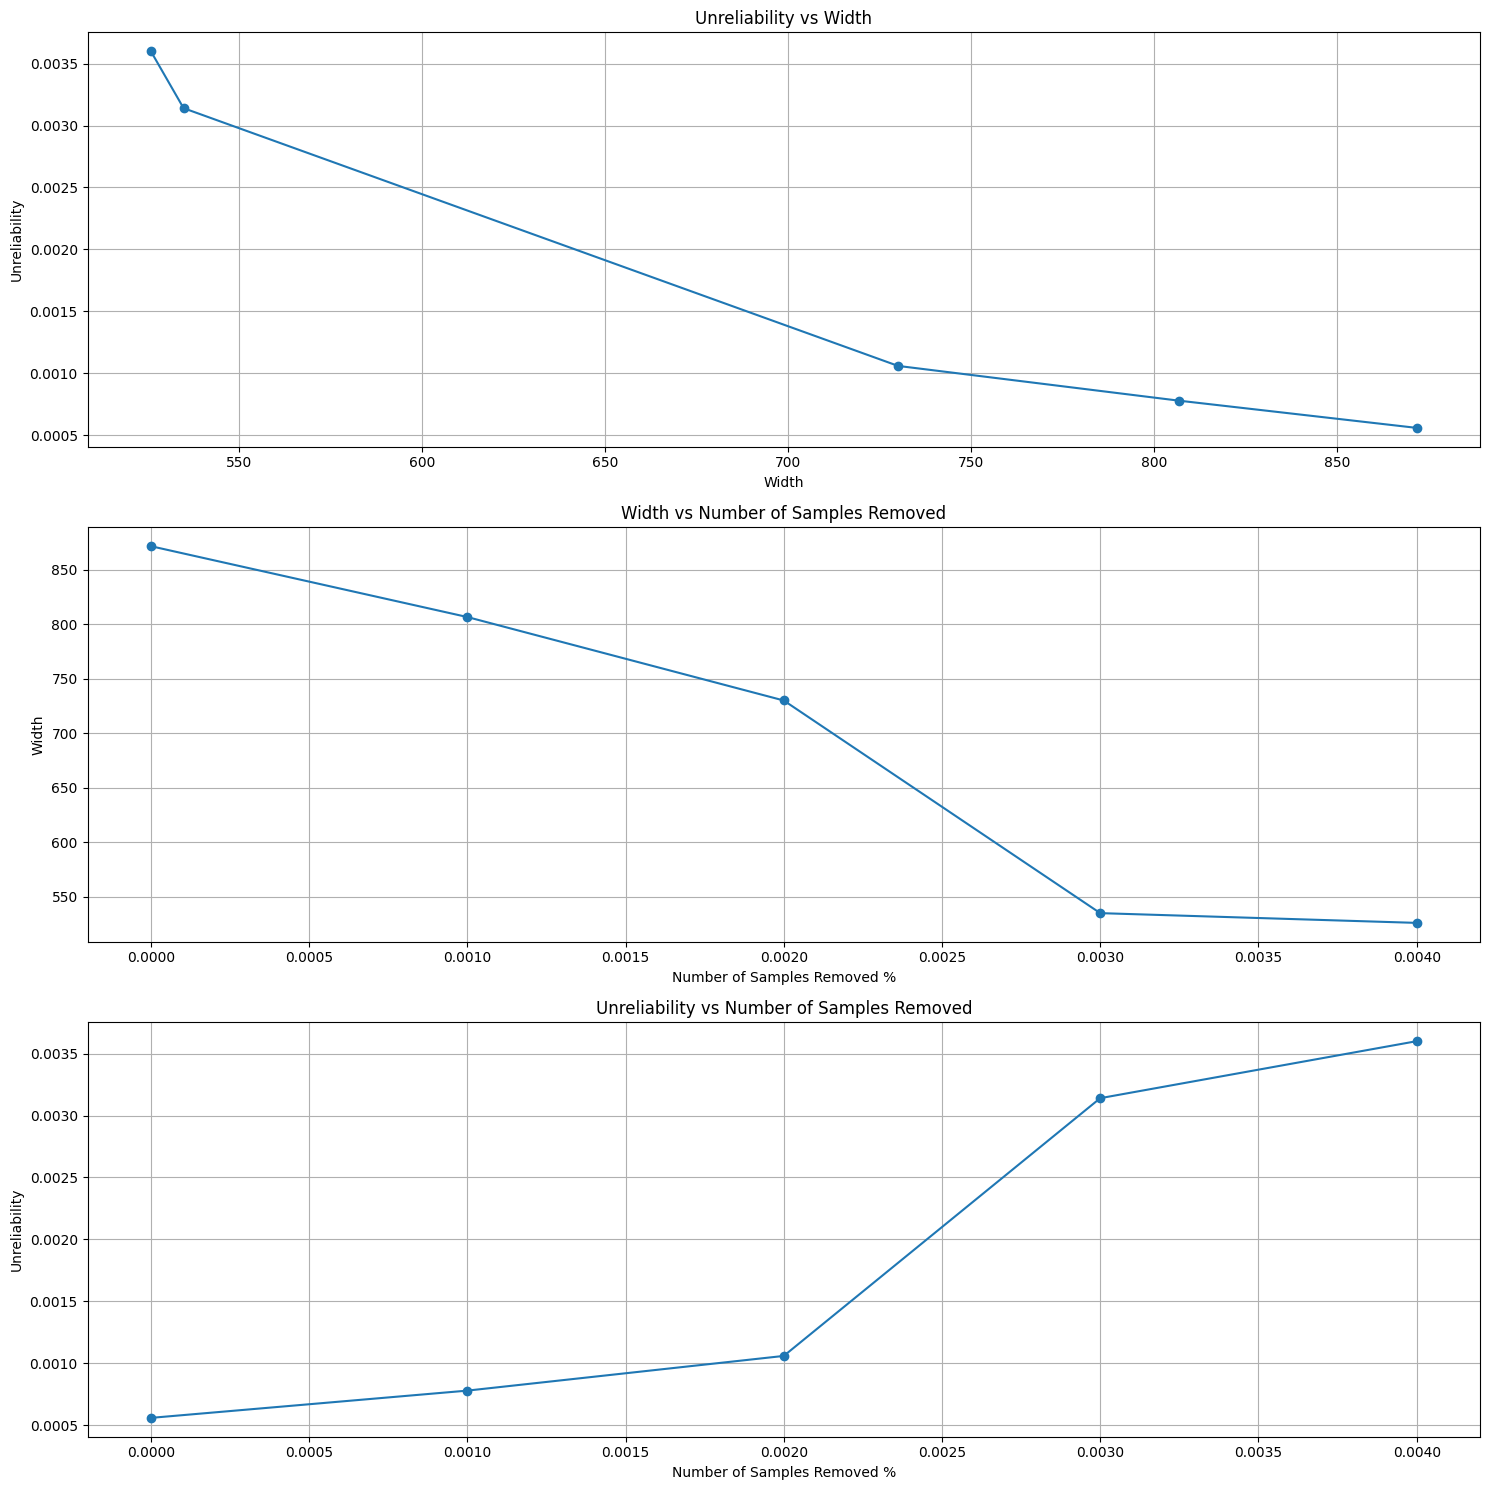

In [154]:
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].plot(width_list, unreliability_pruned_list, '-o')
axes[0].set_xlabel('Width')
axes[0].set_ylabel('Unreliability')
axes[0].set_title('Unreliability vs Width (pareto)')
axes[0].grid(True)

n_removed_list_percent = np.array([(n_start_samples-n)/n_start_samples for n in n_removed_list]).round(3)
axes[1].plot(n_removed_list_percent, width_list, '-o')
axes[1].set_xlabel('Number of Samples Removed %')
axes[1].set_ylabel('Width')
axes[1].set_title('Width vs Number of Samples Removed')
axes[1].grid(True)

axes[2].plot(n_removed_list_percent, unreliability_pruned_list, '-o')
axes[2].set_xlabel('Number of Samples Removed %')
axes[2].set_ylabel('Unreliability')
axes[2].set_title('Unreliability vs Number of Samples Removed')
axes[2].grid(True)

plt.tight_layout()
plt.show()
